In [85]:
%matplotlib inline
from collections import Counter
from matplotlib import pyplot as plt

import json
import yaml

In [86]:
with open('data_prep/vqa_v2.0_cp/vqacp_v2_trainsplit_annotations.json', 'r') as f:
    annotations = json.load(f)

In [87]:
types = {}

for a in annotations:
    qtype = a['question_type']
    if qtype not in types:
        types[qtype] = []
    for answer in a['answers']:
        types[qtype].append(answer['answer'])

In [88]:
types['what sport is']

['soccer',
 'soccer',
 'soccer',
 'soccer',
 'soccer',
 'soccer',
 'soccer',
 'soccer',
 'soccer',
 'soccer',
 'tennis',
 'tennis',
 'tennis',
 'tennis',
 'tennis',
 'tennis',
 'tennis',
 'tennis',
 'tennis',
 'tennis',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboard',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'snowboarding',
 'skiing',
 'snowboarding',
 'snowboarding',
 'snowboarding',
 'snowboarding',
 'snowboarding',
 'snowboarding',
 'snowboarding',
 'snowboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skiing',
 'skiing',
 'skiing',
 'skiing',
 'skiing',
 'skiing',
 'skiing',
 'skiing',
 'skiing',
 'skiing',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'skateboarding',
 'ska

In [89]:
c = Counter(types['what sport is'])

In [90]:
top_k = dict(c.most_common(10))
other_count = sum(c.values()) - sum(top_k.values())
top_k['other'] = other_count
print(top_k)

{'tennis': 9151, 'skiing': 2177, 'skateboarding': 1968, 'soccer': 1910, 'snowboarding': 1471, 'surfing': 1345, 'skateboard': 169, 'water skiing': 128, 'parasailing': 128, 'softball': 118, 'other': 2695}


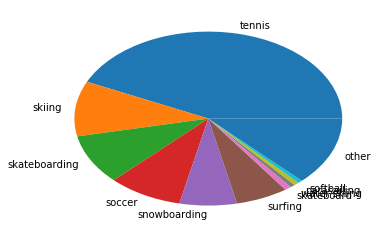

In [91]:
plt.pie([float(v) for v in top_k.values()], labels=top_k.keys(),
           autopct=None)
plt.show()

# VQA model

In [36]:
import numpy as np
import torch

from config.config_utils import finalize_config, dump_config
from train_model.Engineer import one_stage_run_model, masked_unk_softmax
from train_model.dataset_utils import prepare_train_data_set, \
    prepare_eval_data_set, prepare_test_data_set
from train_model.helper import build_model, run_model, print_result
from torch.utils.data import DataLoader

In [10]:
regularized_model_save = 'results/vqa_v2_adv_cp/training_parameters.lambda_grl_start.2000_lambda_grl_steps.4000_888_dragon/best_model.pth'

In [3]:
from config.config import cfg
def process_config(config_file, config_string):
    finalize_config(cfg, config_file, config_string)

process_config('config/keep/vqa_v2_adv_cp.yaml', None)

In [82]:
dataset_test = prepare_test_data_set(**cfg['data'], **cfg['model'])
dataset_test.verbose = True
ans_dic = dataset_test.answer_dict
print("=> Loaded testset: {} examples".format(len(dataset_test)))
data_reader_test = DataLoader(dataset_test,
                              shuffle=True,
                              batch_size=10,
                              num_workers=cfg.data.num_workers)

=> Loading CP dataset
imdb does not contain ground-truth layout
Loading model and config ...
=> Loaded testset: 219928 examples


In [83]:
regularized_model, _ = build_model(cfg, dataset_test)
regularized_model.load_state_dict(torch.load(regularized_model_save)['state_dict'])
regularized_model.eval()

vqa_multi_modal_model(
  (image_embedding_models_list): ModuleList(
    (0): ModuleList(
      (0): image_embedding(
        (image_attention_model): top_down_attention(
          (modal_combine): non_linear_elmt_multiply(
            (Fa_image): nonlinear_layer(
              (main): Sequential(
                (0): Linear(in_features=2048, out_features=5000, bias=True)
                (1): ReLU()
              )
            )
            (Fa_txt): nonlinear_layer(
              (main): Sequential(
                (0): Linear(in_features=2048, out_features=5000, bias=True)
                (1): ReLU()
              )
            )
            (dropout): Dropout(p=0)
          )
          (transform): LinearTransform(
            (lc): Linear(in_features=5000, out_features=1, bias=True)
          )
        )
      )
    )
  )
  (question_embedding_models): ModuleList(
    (0): AttQuestionEmbedding(
      (embedding): Embedding(15333, 300)
      (LSTM): LSTM(300, 1024, batch_first=True)


In [84]:
# question_ids, soft_max_result = run_model(regularized_model, data_reader_test, ans_dic.UNK_idx)

In [94]:
for i, batch in enumerate(data_reader_test):
    logit_res = one_stage_run_model(batch, regularized_model, eval_mode=True)
    softmax_res = masked_unk_softmax(logit_res, dim=1, mask_idx=ans_dic.UNK_idx)
    softmax_res = softmax_res.data.cpu().numpy().astype(np.float16)
    
    q_ids = batch['verbose_info']['question_id'].cpu().numpy().tolist()
    
    break

In [95]:
softmax_res.shape

(10, 3129)

In [96]:
def display_result(info, softmax_res):
    questions = info['question_str']
    images = info['image_name']
    predicted_answers = np.argmax(softmax_res, axis=1)
    for i in range(predicted_answers.shape[0]):
        pred_ans = ans_dic.idx2word(predicted_answers[i])
        print(questions[i], images[i], pred_ans)

In [97]:
display_result(batch['verbose_info'], softmax_res)

Is this in the countryside? COCO_train2014_000000436580 no
Are both bowls full? COCO_train2014_000000080931 no
Is the person male or female? COCO_train2014_000000307322 male
What color is the chair? COCO_val2014_000000190372 black
Is this a cordless phone or cord phone? COCO_train2014_000000299105 flip phone
How many screens are there? COCO_val2014_000000373713 2
Can this animal fly? COCO_train2014_000000399016 no
What color is the persons jacket in the background? COCO_val2014_000000395182 black
In order to pay by phone for this meter, what number does one need to call? COCO_val2014_000000053994 3
Is this have carrots in it? COCO_train2014_000000373511 no


In [73]:
batch['verbose_info']

{'image_name': ['COCO_train2014_000000166207',
  'COCO_train2014_000000393900',
  'COCO_train2014_000000349897',
  'COCO_train2014_000000529229',
  'COCO_train2014_000000009960',
  'COCO_train2014_000000009960',
  'COCO_train2014_000000273704',
  'COCO_train2014_000000539372',
  'COCO_train2014_000000278297',
  'COCO_train2014_000000278297'],
 'image_id': tensor([166207, 393900, 349897, 529229,   9960,   9960, 273704, 539372, 278297,
         278297]),
 'question_id': tensor([166207005, 393900007, 349897005, 529229003,   9960003,   9960010,
         273704004, 539372001, 278297001, 278297005]),
 'feature_path': ['COCO_train2014_000000166207.npy',
  'COCO_train2014_000000393900.npy',
  'COCO_train2014_000000349897.npy',
  'COCO_train2014_000000529229.npy',
  'COCO_train2014_000000009960.npy',
  'COCO_train2014_000000009960.npy',
  'COCO_train2014_000000273704.npy',
  'COCO_train2014_000000539372.npy',
  'COCO_train2014_000000278297.npy',
  'COCO_train2014_000000278297.npy'],
 'question_

In [ ]:
# 
# INPUT: model, batch
# OUTPUT: dist_over_answer